In [33]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [26]:
transform = transforms.Compose([
    transforms.RandomRotation(30),  # Randomly rotate by 15 degrees
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)), # Randomly crop and resize
    transforms.RandomHorizontalFlip(), # Randomly flip horizontally
    transforms.ToTensor(), # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)) # Normalize
])

In [52]:
train_dataset = datasets.FashionMNIST(
    root='./data',  
    train=True,   
    download=True, 
    transform=transform
)

# Load the test dataset
test_dataset = datasets.FashionMNIST(
    root='./data',  
    train=False,    
    download=True, 
    transform=transform
)

In [53]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_epochs = 15
batch_size = 64
learning_rate = 0.01


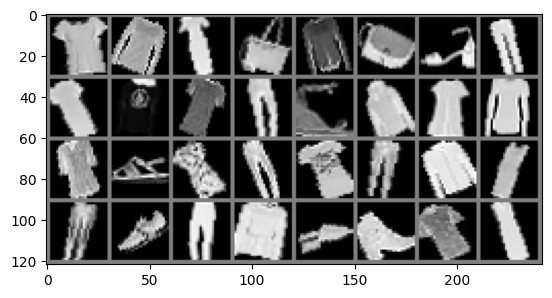

T-shirt/top Pullover Dress Bag   Pullover Bag   Sandal Trouser Dress Pullover T-shirt/top Trouser Sandal Coat  Dress Pullover Shirt Sandal Dress Trouser T-shirt/top Trouser Coat  Dress Trouser Sneaker Trouser Pullover Sandal Ankle boot Shirt Dress


In [37]:
def imshow(img):
    img = img / 2 + 0.5  # Denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Rearrange dimensions for matplotlib
    plt.show()

# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Make a grid of images
img_grid = torchvision.utils.make_grid(images)

# Display the image grid
imshow(img_grid)

# Print the labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))

In [39]:
class BasicBlock(nn.Module):
    expansion = 1 # No expansion of channels in the basic block

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection to match dimensions if they change (e.g., due to stride)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Add the shortcut connection's output
        out += self.shortcut(identity)
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        # Initial convolution (adapted for MNIST's 1 channel)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # Stacking residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        # Final layers
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [18]:
model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [41]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
print("\nStarting Training... 🚀")
total_steps = len(trainloader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')
    scheduler.step()


Starting Training... 🚀
Epoch [1/15], Step [200/1875], Loss: 0.2887
Epoch [1/15], Step [400/1875], Loss: 0.3009
Epoch [1/15], Step [600/1875], Loss: 0.2423
Epoch [1/15], Step [800/1875], Loss: 0.1917
Epoch [1/15], Step [1000/1875], Loss: 0.0516
Epoch [1/15], Step [1200/1875], Loss: 0.3585
Epoch [1/15], Step [1400/1875], Loss: 0.1843
Epoch [1/15], Step [1600/1875], Loss: 0.1496
Epoch [1/15], Step [1800/1875], Loss: 0.1677
Epoch [2/15], Step [200/1875], Loss: 0.4218
Epoch [2/15], Step [400/1875], Loss: 0.1576
Epoch [2/15], Step [600/1875], Loss: 0.2479
Epoch [2/15], Step [800/1875], Loss: 0.1831
Epoch [2/15], Step [1000/1875], Loss: 0.3179
Epoch [2/15], Step [1200/1875], Loss: 0.1355
Epoch [2/15], Step [1400/1875], Loss: 0.3832
Epoch [2/15], Step [1600/1875], Loss: 0.0847
Epoch [2/15], Step [1800/1875], Loss: 0.4013
Epoch [3/15], Step [200/1875], Loss: 0.1613
Epoch [3/15], Step [400/1875], Loss: 0.1219
Epoch [3/15], Step [600/1875], Loss: 0.2981
Epoch [3/15], Step [800/1875], Loss: 0.148

In [54]:
print("\nEvaluating Model...")
model.eval()  # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculation
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the 10000 test images: {accuracy:.2f} %')


Evaluating Model...
Accuracy of the model on the 10000 test images: 92.45 %
